In [17]:
import cv2
import mahotas
import matplotlib.pyplot as plt
import numpy as np
import skopt
import warnings

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from skopt import BayesSearchCV
from skopt.plots import plot_objective
import shap

# Preprocessing danych

Funkcja loadData wczytuje dane z katalogu. Dane powinny znajdować się w podkatalogach: hits_votes_4_Dots, hits_votes_4_Lines, hits_votes_4_Worms i hits_votes_4_artefacts (artefakty nie są używane w ramach tego projektu). Zwracane listy zawierają zdjęcia śladów promieniowania kosmicznego (images) oraz ich klasy (targets).

In [18]:
# Source: https://github.com/credo-science/CREDO-ML/blob/main/offline_trigger/Wavelet_BINARY_ALFA.ipynb
def loadData(path, verbose=True):

  import cv2
  import glob

  dots = []
  lines = []
  worms = []
  artefacts = []

  for img in glob.glob(path+"hits_votes_4_Dots/*.png"):
      n = cv2.imread(img)
      dots.append(n)
  target_dots = ['dots' for _ in dots]

  for img in glob.glob(path+"hits_votes_4_Lines/*.png"):
      n = cv2.imread(img)
      lines.append(n)
  target_lines = ['lines' for _ in lines]

  for img in glob.glob(path+"hits_votes_4_Worms/*.png"):
      n = cv2.imread(img)
      worms.append(n)
  target_worms = ['worms' for _ in worms]

#   for img in glob.glob(path+"artefacts/*.png"):
#       n = cv2.imread(img)
#       artefacts.append(n)
#   target_artefacts = [3 for _ in artefacts]

  images=dots+lines+worms#+artefacts

  #target_signals_binary = [0 for _ in (dots+lines+worms)]
  #target_artefacts_binary = [1 for _ in artefacts]

  #targets=target_signals_binary+target_artefacts_binary
  targets=target_dots+target_lines+target_worms#+target_artefacts

  if verbose:
    print(len(images),len(targets))
    print(images[0].shape)
    print(len(dots), len(lines), len(worms), len(artefacts))


  return (images, targets)

Funkcja normalizuje dane wejściowe (momenty Zernike) i dokonuje redukcji PCA.

In [19]:
def pca_reduction(X: np.ndarray, n_components: int, verbose: bool = True):
    """Function for Principal Component Analysis (PCA).

    Args:
        X (np.ndarray): Input data.
        n_components (int): Number of components for PCA reduction.
        verbose (bool): When True print sum of explained variance ratio.

    Returns:
        ret (np.ndarray): Data after PCA.
    """
    X_norm = preprocessing.normalize(X)

    pca = PCA(n_components=n_components)
    pca.fit(X_norm)

    ret = pca.transform(X_norm)

    if verbose:
        print(f'Sum of explained variance ratio: {pca.explained_variance_ratio_.sum()}')

    return ret

Funkcja preprocess_data w pierwszej kolejności dokonuje rozmycia danych filtrem Gaussa, a następnie progowanie zdjęcia metodą OTSU. Następnie ze zdjęcia wyliczane są momenty Zernike, o określonym promieniu (promieniu okręgu, który zostanie nałożony na środek masy obrazu - piksele poza tym okręgiem będą ignorowane) i stopniu wielomianów (jest to maksymalny stopień wielomianów które będą używane). Momenty Zernike służą do charakteryzowania obiektów na obrazach. Po obliczeniu są traktowane jako wektory cech. Otrzymane momenty Zernike są poddawane redukcji PCA.

In [20]:
def preprocess_data(X: list, blur_ksize: tuple, thresh_min: int, thresh_max: int, zernike_radius: int, zernike_degree: int, skip_pca: bool, pca_num_components: int, pca_verbose: bool) -> np.ndarray:
    """Preprocess data.

    Args:
        X (list): Input data.
        blur_ksize (tuple): Blur kernel size.
        thresh_min (int): Threshold minimal value.
        thresh_max (int): Threshold maximal value.
        zernike_radius (int): Zernike moments radius.
        zernike_degree (int): Zernike moments degree.
        skip_pca (bool): When true PCA will be skipped.
        pca_num_components (int): Number of components for PCA reduction.
        pca_verbose (bool): When True PCA prints sum of explained variance ratio.

    Returns:
        ret (np.ndarray): Preprocessed data.
    """
    dim: int = mahotas.features.zernike_moments(
        cv2.cvtColor(X[0], cv2.COLOR_RGB2GRAY), zernike_radius, zernike_degree
        ).shape[0]
    
    ret: np.ndarray = np.zeros((len(X), dim))
    for i in range(len(X)):

        # Preprocess image before extracting zernike moments
        img: np.ndarray = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
        img = cv2.GaussianBlur(img, blur_ksize, 0)
        _, img = cv2.threshold(img, thresh_min, thresh_max, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Extract zernike moments
        zernike: np.ndarray = mahotas.features.zernike_moments(img, zernike_radius, zernike_degree)
        
        ret[i,:] = zernike
    
    # PCA dimensionality reduction
    if not skip_pca:
        ret = pca_reduction(ret, pca_num_components, pca_verbose)
        
    return ret

In [21]:
def plot_confusion_matrix(y_test: list, y_pred: list, model: any):
    """Display confusion matrix.

    Args:
        y_test (list): Target classes.
        y_pred (list): Predicted classes.
        model (ClassifierMixin): Model used for prediction.
    """
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

In [22]:
def jackknife(X: np.ndarray, y: np.ndarray, model: any, n_samples: int, seed: int) -> float:
    """Function for Jackknife resampling method.

    Args:
        X (np.ndarray): Input data.
        y (np.ndarray): Input classes.
        model (any): Selected model.
        n_samples (int): Number of samples for Jackknife.
    """
    
    p = np.random.RandomState(seed=seed).permutation(len(X))
    X = X[p] 
    y = y[p]
    
    model.fit(X, y)
    all_data_score = model.score(X, y)

    sample_size = int(len(X)/n_samples)
    
    scores = np.zeros((n_samples,1), dtype=np.float16)
    for i in range(n_samples):
        start = i*sample_size
        stop = (i+1)*sample_size

        X_train = np.delete(X, np.s_[start:stop], axis=0)
        y_train = np.delete(y, np.s_[start:stop], axis=0)

        X_test = X[start:stop]
        y_test = y[start:stop]
        
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        scores[i] = all_data_score - score
    
    return np.mean(scores)

In [7]:
def bootstrap(X: np.ndarray, y: np.ndarray, model: any, n_samples: int):
    """Function for Bootstrap resampling method.

    Args:
        X (np.ndarray): Input data.
        y (np.ndarray): Input classes.
        model (any): Selected model.
        n_samples (int): Number of samples for Bootstrap.
    """
    classes = np.unique(y)
    num_classes = classes.shape[0]
    accuracy = np.zeros((1 + num_classes, n_samples), dtype=np.float16)
    for i in range(n_samples):
        X_bs, y_bs = resample(X, y, replace=True)
        # make predictions
        y_hat = model.predict_proba(X_bs)
        # evaluate model

    class0 = y_hat[:, 0]
    class1 = y_hat[:, 1]
    class2 = y_hat[:, 2]

    binno=100

    counts, bins = np.histogram(class0, binno)
    plt.stairs(np.log10(counts), bins)

    counts, bins = np.histogram(class1, binno)
    plt.stairs(np.log10(counts), bins)

    counts, bins = np.histogram(class2, binno)
    plt.stairs(np.log10(counts), bins)

    plt.legend(['dots','lines','worms'])

    plt.show()

Po wczytaniu danych dokonujemy ich preprocessingu (dwukrotnie).

In [23]:
path="../data/hit-images-final/"

X_, y = loadData(path, False)

Za pierwszym razem otrzymujemy dane treningowe i testowe które posłużą do trenowania modelu, wymiarowość tych danych jest redukowana do 8 komponentów i dokonywany jest podział przy pomocy metody train_test_split.

In [28]:
blur_ksize = (5, 5)
thresh_min = 0
thresh_max = 255 
zernike_radius = 30
zernike_degree = 28
pca_num_components = 8
pca_verbose = True
jk_samples = 5
jk_seed = 0
bs_samples = 10000

X = preprocess_data(X_, blur_ksize, thresh_min, thresh_max, zernike_radius, zernike_degree, False, pca_num_components, pca_verbose)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Sum of explained variance ratio: 0.9377061090655487


Za drugim razem wybieramy mniejszy stopień wielomianów używanych do wyliczania momentów Zernike oraz pomijamy redukcje PCA. Tak przygotowane dane mają posłużyć analizie SHAP poszczególnych modeli.

In [29]:
zernike_radius_shap = 30
zernike_degree_shap = 4
X_shap = preprocess_data(X_, blur_ksize, thresh_min, thresh_max, zernike_radius_shap, zernike_degree_shap, True, pca_num_components, pca_verbose)
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_shap, y, test_size=0.2, random_state=0)

In [30]:
print(X_train.shape)
print(X_train_shap.shape)

(985, 8)
(985, 9)


# SVC

## Bayesian optimization

In [31]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
opt = BayesSearchCV(
    SVC(), 
    {
        'C': [1.0, 100, 1e-6, 1e+6,],
        'gamma': [1e-6, 1e+1, 'log-uniform'],
        'degree': [1, 3, 8],
        'kernel': ['linear', 'poly', 'rbf'],
    },
    n_iter = 100,
    cv = 5,
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9279187817258883
test. score 0.9149797570850202
best params OrderedDict([('C', 100.0), ('degree', 1), ('gamma', 10.0), ('kernel', 'rbf')])


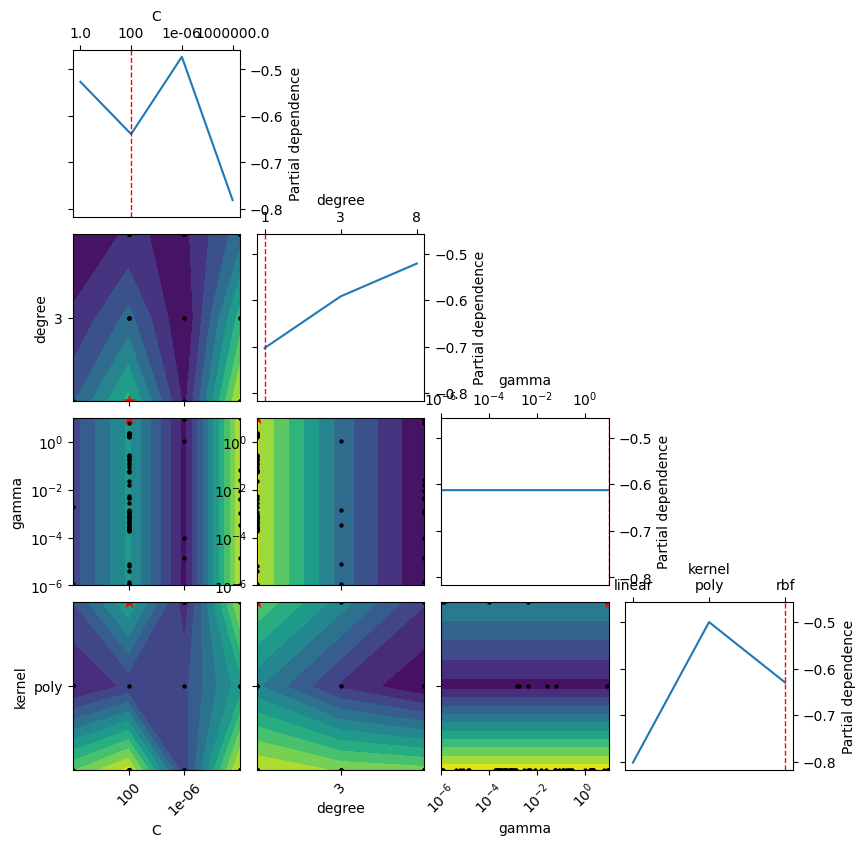

In [32]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

## Optimized model prediction

Training accuracy: 0.9746192893401016
Test accuracy: 0.9149797570850202


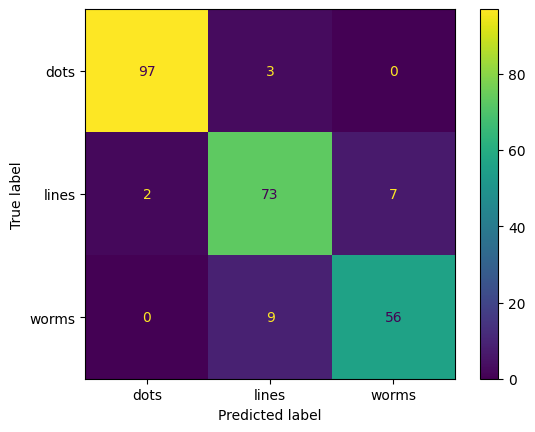

In [33]:
svc = SVC(**opt.best_params_, probability=True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
train_accuracy = accuracy_score(y_train, svc.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')
plot_confusion_matrix(y_test, y_pred, svc)

## Shap

In [34]:
shap.initjs()

svc_shap = SVC(probability=True)
svc_shap.fit(X_train_shap, y_train_shap)

svc_explainer = shap.KernelExplainer(svc_shap.predict_proba, X_train_shap[:300])
svc_shap_values = svc_explainer.shap_values(X_test_shap)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 247/247 [09:57<00:00,  2.42s/it]


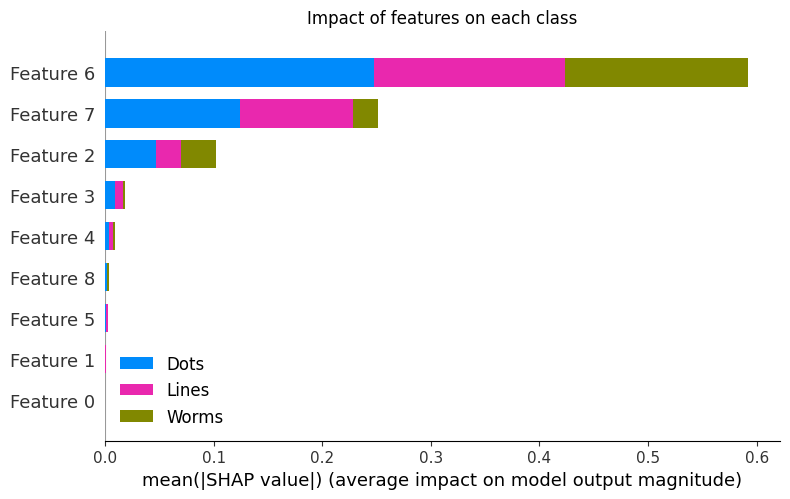

In [35]:
plt.title('Impact of features on each class')
shap.summary_plot(svc_shap_values, X_test_shap, class_names=['Dots', 'Lines', 'Worms'])

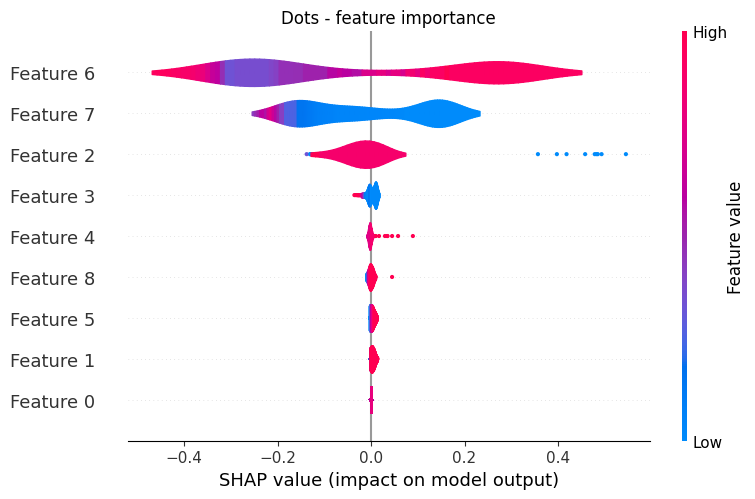

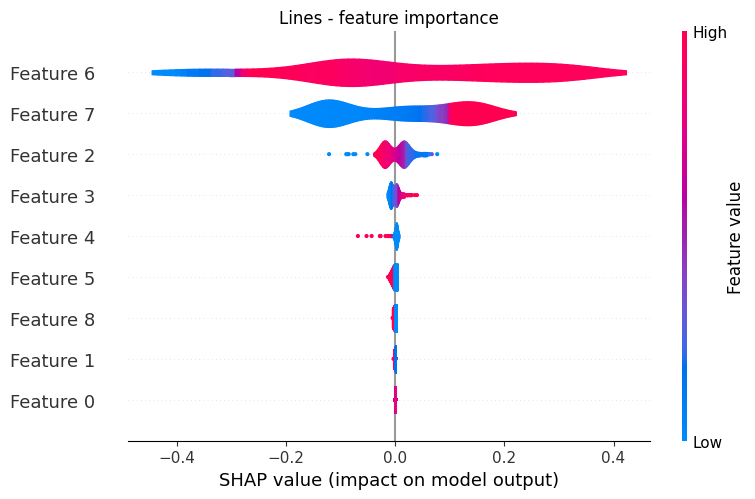

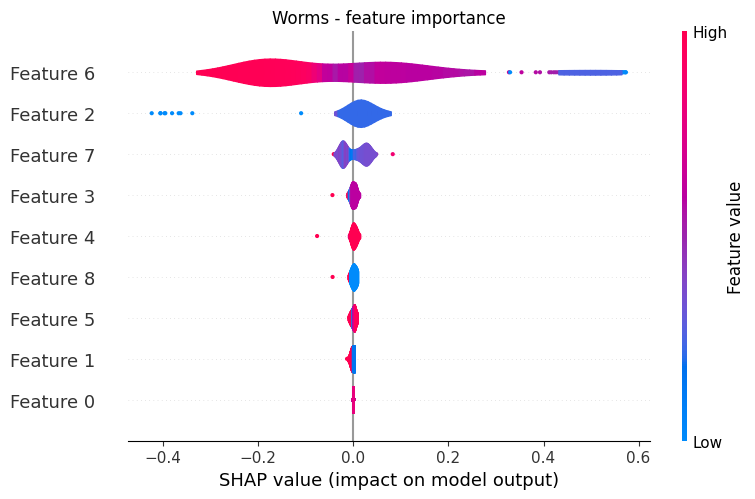

In [36]:
plt.title('Dots - feature importance')
shap.summary_plot(svc_shap_values[0], X_test_shap, plot_type='violin')

plt.title('Lines - feature importance')
shap.summary_plot(svc_shap_values[1], X_test_shap, plot_type='violin')

plt.title('Worms - feature importance')
shap.summary_plot(svc_shap_values[2], X_test_shap, plot_type='violin')

## Bootstrap

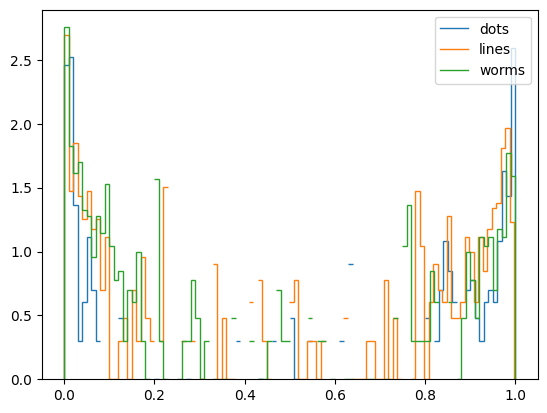

In [37]:
warnings.filterwarnings('ignore', message='divide by zero encountered in log10')
bootstrap(X, np.asarray(y), svc, bs_samples)

## Jackknife cross-validation

In [38]:
svc_jk = jackknife(X, np.asarray(y), svc, jk_samples, jk_seed)
print(f'Jackknife score: {svc_jk}')

Jackknife score: 0.04150390625


# KNN

## Bayesian optimization

In [43]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
opt = BayesSearchCV(
    KNeighborsClassifier(), 
    {
        "n_neighbors": (3, 5, 7, 9, 11),
        "weights": ["uniform", "distance"],
        "algorithm": [ "ball_tree", "kd_tree", "brute"],
        "p": (1,2),
        "leaf_size": (10, 20, 30, 40, 50)
    },
    n_iter = 100,
    cv = 5
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9289340101522843
test. score 0.9149797570850202
best params OrderedDict([('algorithm', 'brute'), ('leaf_size', 50), ('n_neighbors', 3), ('p', 2), ('weights', 'distance')])


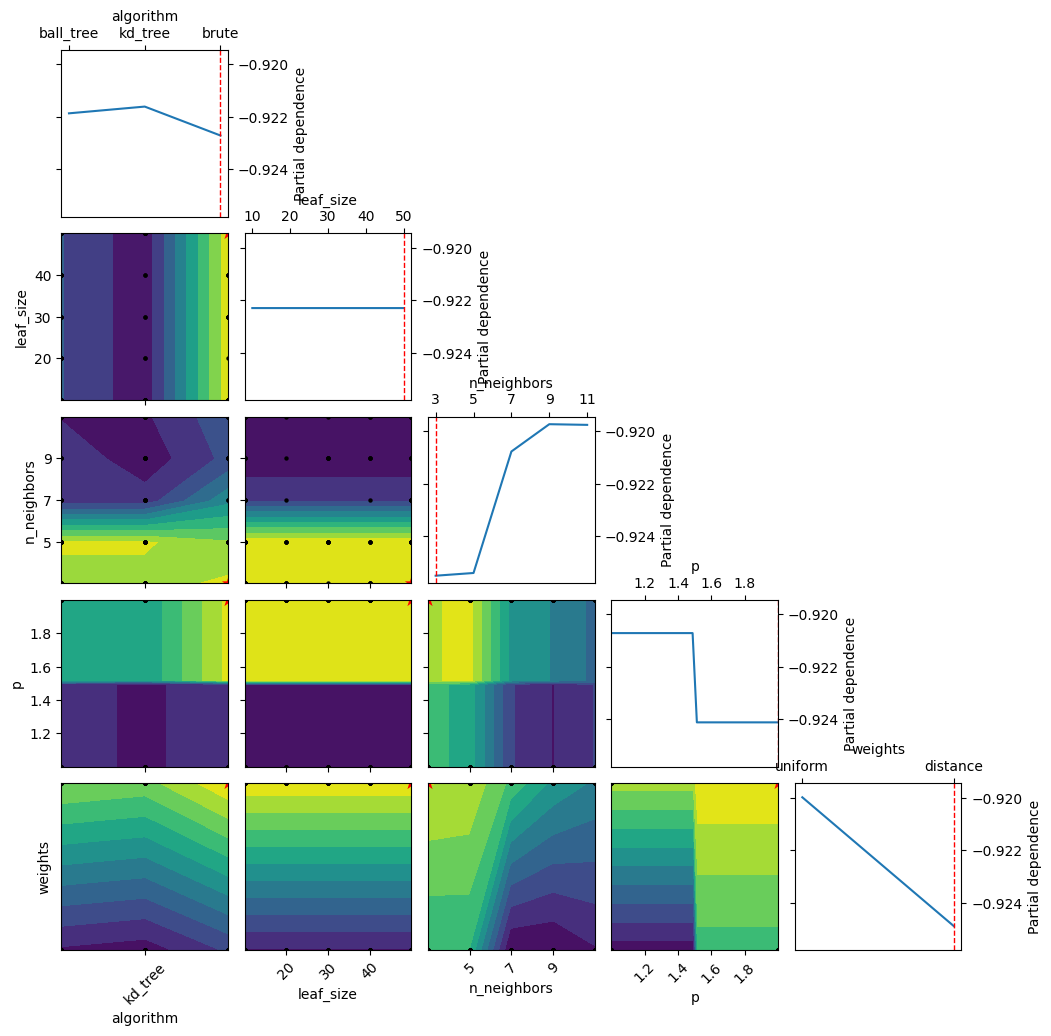

In [44]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

## Optimized model prediction

Training accuracy: 0.9979695431472081
Test accuracy: 0.9149797570850202


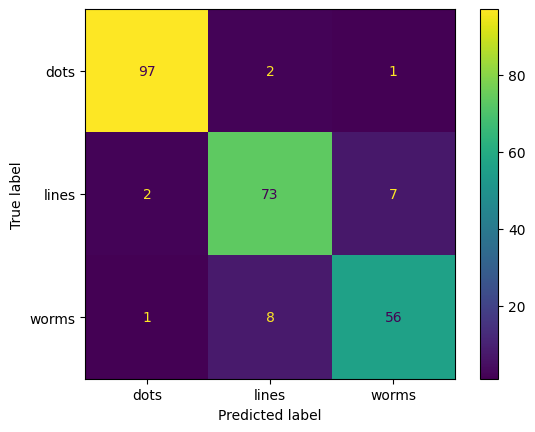

In [45]:
knn = KNeighborsClassifier(**opt.best_params_)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
train_accuracy = accuracy_score(y_train, knn.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')
plot_confusion_matrix(y_test, y_pred, knn)

## Shap

In [46]:
shap.initjs()

knn_shap = KNeighborsClassifier()
knn_shap.fit(X_train_shap, y_train_shap)

knn_explainer = shap.KernelExplainer(knn_shap.predict_proba, X_train_shap[:300])
knn_shap_values = knn_explainer.shap_values(X_test_shap)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 247/247 [03:14<00:00,  1.27it/s]


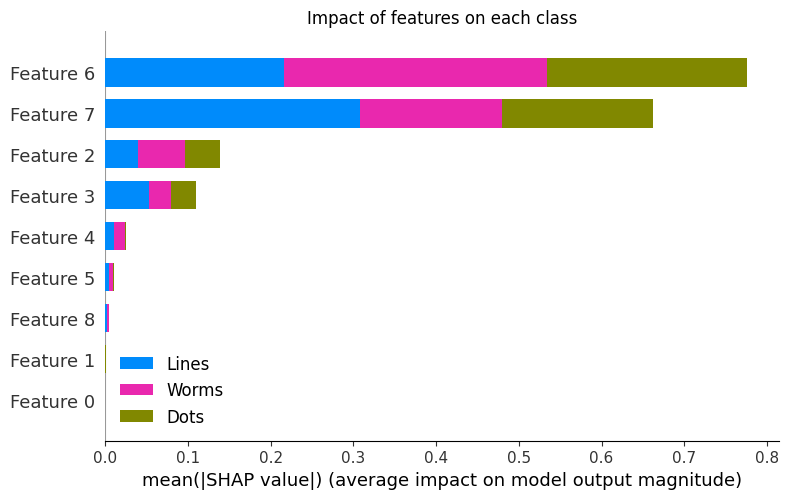

In [47]:
plt.title('Impact of features on each class')
shap.summary_plot(knn_shap_values, X_test_shap, class_names=['Dots', 'Lines', 'Worms'])

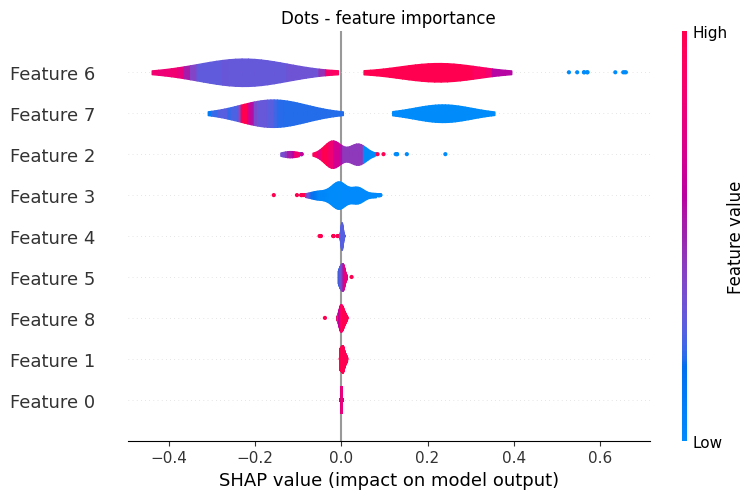

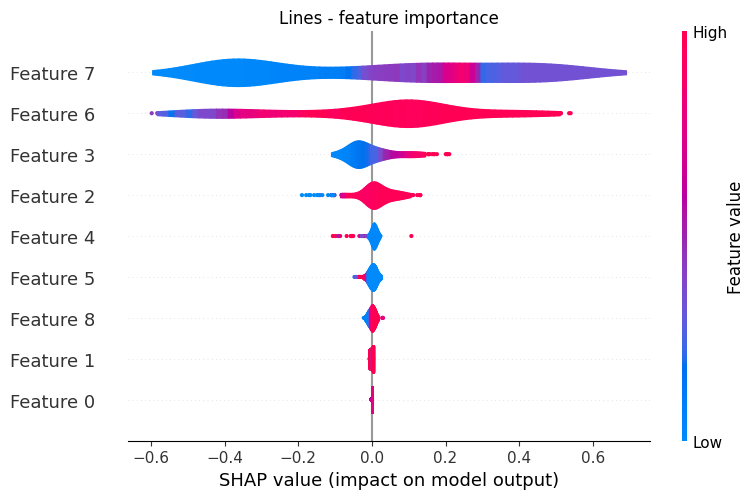

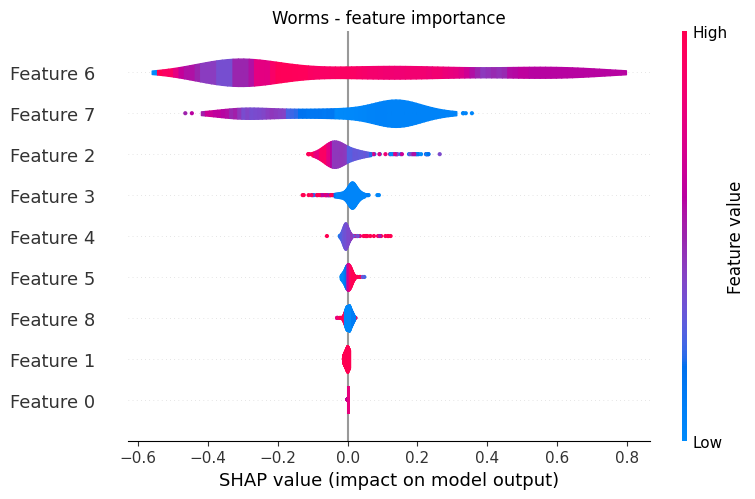

In [48]:
plt.title('Dots - feature importance')
shap.summary_plot(knn_shap_values[0], X_test_shap, plot_type='violin')

plt.title('Lines - feature importance')
shap.summary_plot(knn_shap_values[1], X_test_shap, plot_type='violin')

plt.title('Worms - feature importance')
shap.summary_plot(knn_shap_values[2], X_test_shap, plot_type='violin')

## Bootstrap

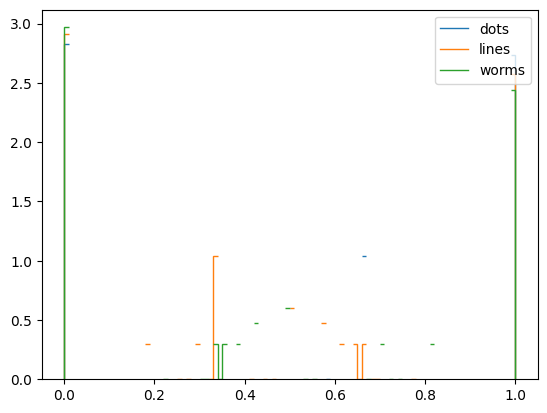

In [49]:
warnings.filterwarnings('ignore', message='divide by zero encountered in log10')
bootstrap(X, np.asarray(y), knn, bs_samples)

## Jackknife cross-validation

In [50]:
knn_jk = jackknife(X, np.asarray(y), knn, jk_samples, jk_seed)
print(f'Jackknife score: {knn_jk}')

Jackknife score: 0.069091796875


# RFC

## Bayesian optimization

In [51]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
opt = BayesSearchCV(
    RandomForestClassifier(), 
    {
        'n_estimators': (10, 50, 100, 200),
        'criterion': ['gini', 'entropy'],
        'max_features': ["sqrt", "log2", None],
    },
    n_iter = 100,
    cv = 5,
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9401015228426397
test. score 0.9311740890688259
best params OrderedDict([('criterion', 'entropy'), ('max_features', 'sqrt'), ('n_estimators', 200)])


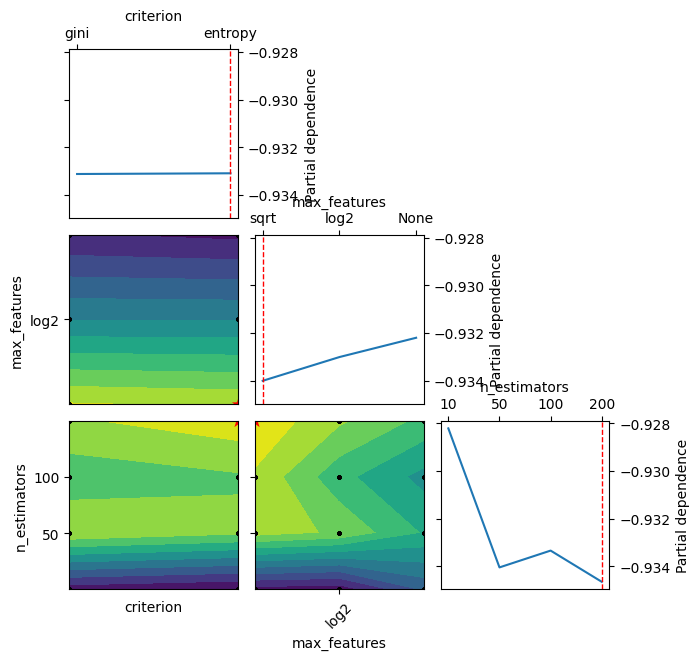

In [52]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

## Optimized model prediction

Training accuracy: 0.9939086294416244
Test accuracy: 0.9190283400809717


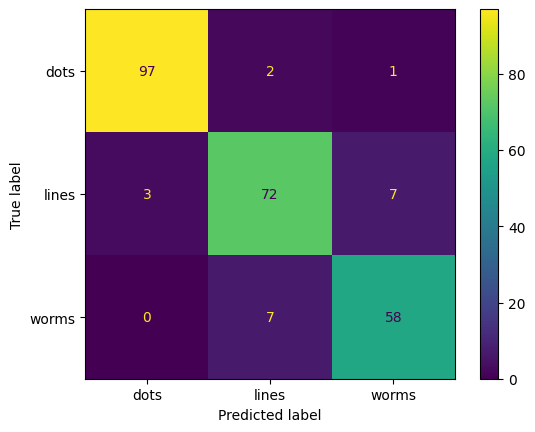

In [53]:
rfc = RandomForestClassifier(**opt.best_params_)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
train_accuracy = accuracy_score(y_train, rfc.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')
plot_confusion_matrix(y_test, y_pred, rfc)

## Shap

In [54]:
shap.initjs()

rfc_shap = RandomForestClassifier()
rfc_shap.fit(X_train_shap, y_train_shap)

rfc_explainer = shap.TreeExplainer(rfc_shap)
rfc_shap_values = rfc_explainer.shap_values(X_test_shap)

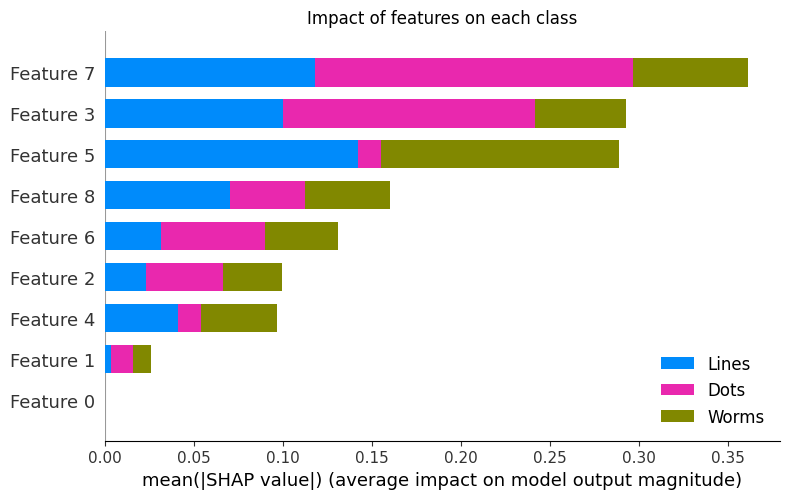

In [55]:
plt.title('Impact of features on each class')
shap.summary_plot(rfc_shap_values, X_test_shap, class_names=['Dots', 'Lines', 'Worms'])

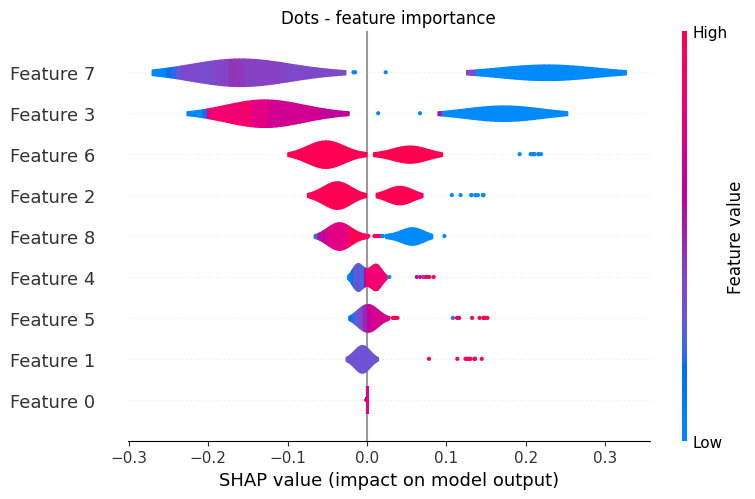

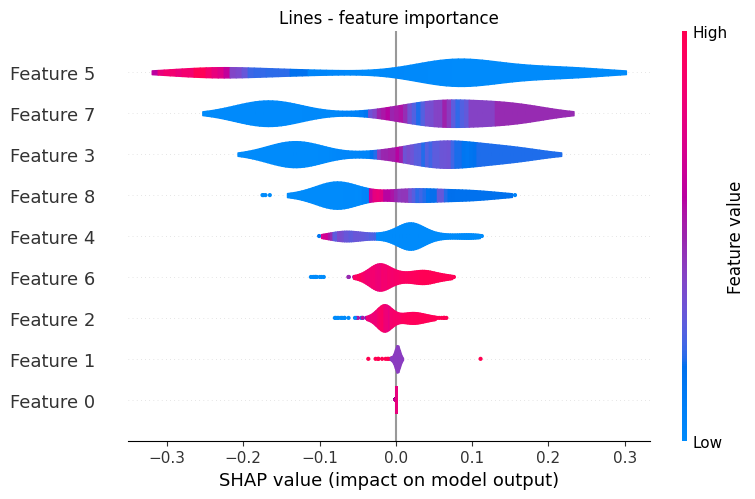

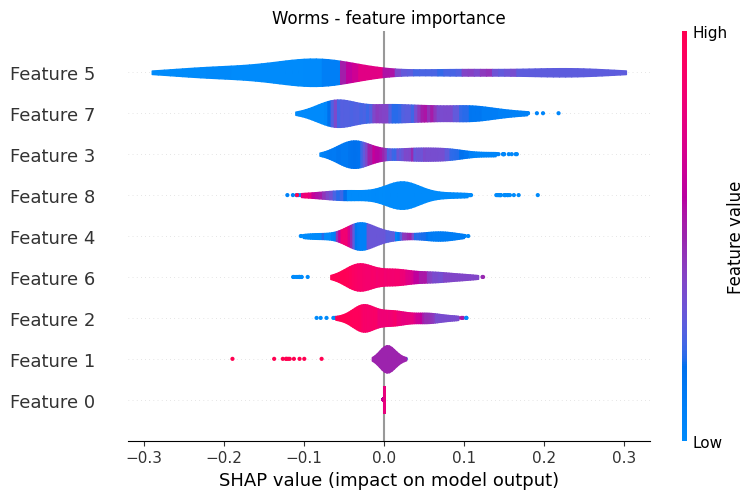

In [56]:
plt.title('Dots - feature importance')
shap.summary_plot(rfc_shap_values[0], X_test_shap, plot_type='violin')

plt.title('Lines - feature importance')
shap.summary_plot(rfc_shap_values[1], X_test_shap, plot_type='violin')

plt.title('Worms - feature importance')
shap.summary_plot(rfc_shap_values[2], X_test_shap, plot_type='violin')

## Bootstrap

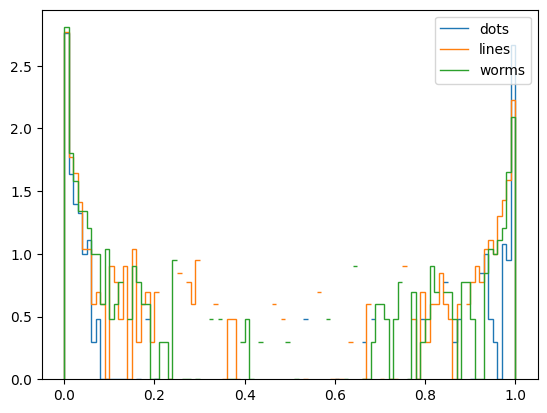

In [57]:
warnings.filterwarnings('ignore', message='divide by zero encountered in log10')
bootstrap(X, np.asarray(y), rfc, bs_samples)

## Jackknife cross-validation

In [58]:
rfc_jk = jackknife(X, np.asarray(y), rfc, jk_samples, jk_seed)
print(f'Jackknife score: {rfc_jk}')

Jackknife score: 0.059356689453125


# MLP

## Bayesian optimization

In [59]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
warnings.filterwarnings('ignore', message='.*converge.*')
opt = BayesSearchCV(
    MLPClassifier(max_iter=1000), 
    {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [1e-5, 1e-4, 1e-3],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
    },
    n_iter = 100,
    cv = 5,
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9401015228426395
test. score 0.9109311740890689
best params OrderedDict([('activation', 'relu'), ('alpha', 0.001), ('learning_rate', 'invscaling'), ('solver', 'adam')])


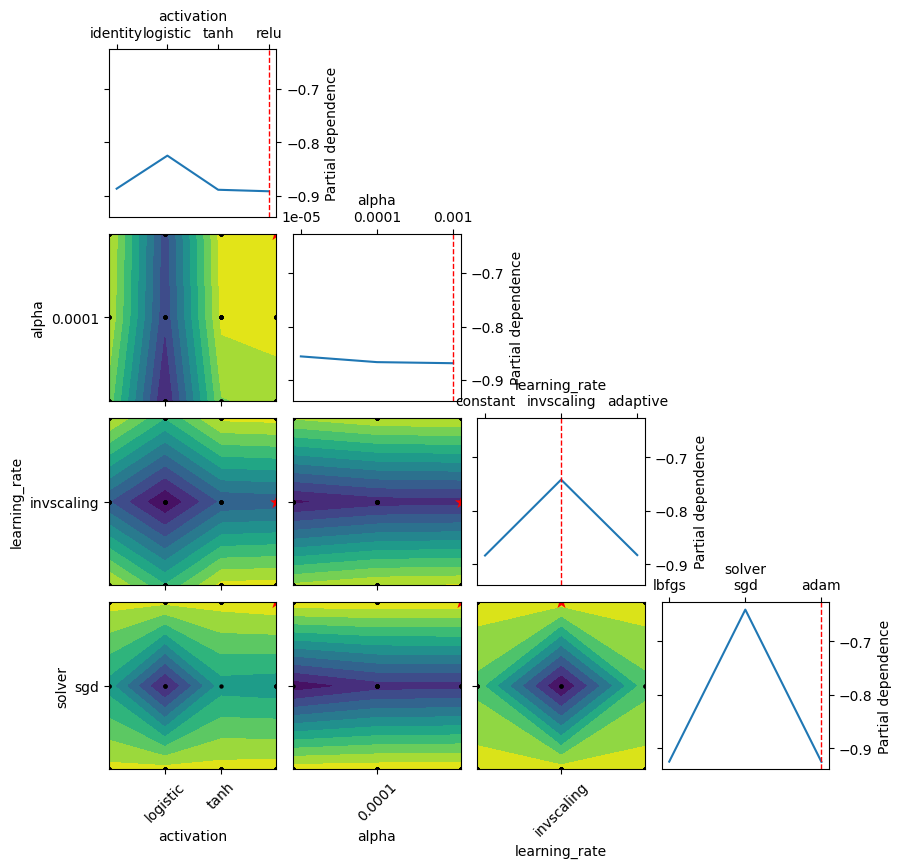

In [60]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

## Optimized model prediction

Training accuracy: 0.9583756345177665
Test accuracy: 0.9149797570850202


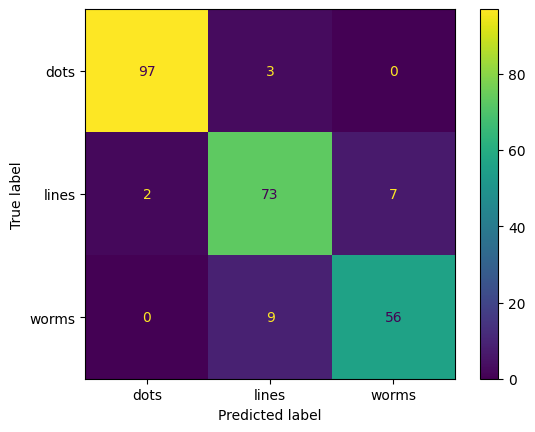

In [61]:
mlp = MLPClassifier(**opt.best_params_, max_iter=1000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
train_accuracy = accuracy_score(y_train, mlp.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')
plot_confusion_matrix(y_test, y_pred, mlp)

In [62]:
shap.initjs()

mlp_shap = MLPClassifier()
mlp_shap.fit(X_train_shap, y_train_shap)

mlp_explainer = shap.KernelExplainer(mlp_shap.predict_proba, X_train_shap[:300])
mlp_shap_values = mlp_explainer.shap_values(X_test_shap)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 247/247 [01:37<00:00,  2.54it/s]


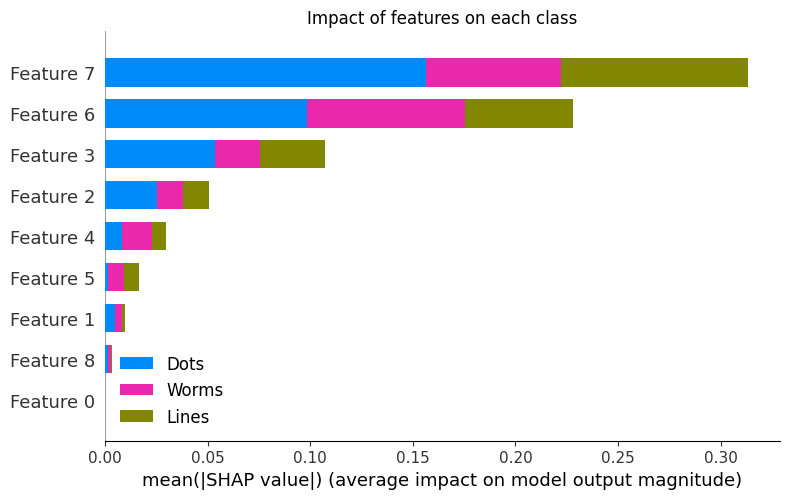

In [63]:
plt.title('Impact of features on each class')
shap.summary_plot(mlp_shap_values, X_test_shap, class_names=['Dots', 'Lines', 'Worms'])

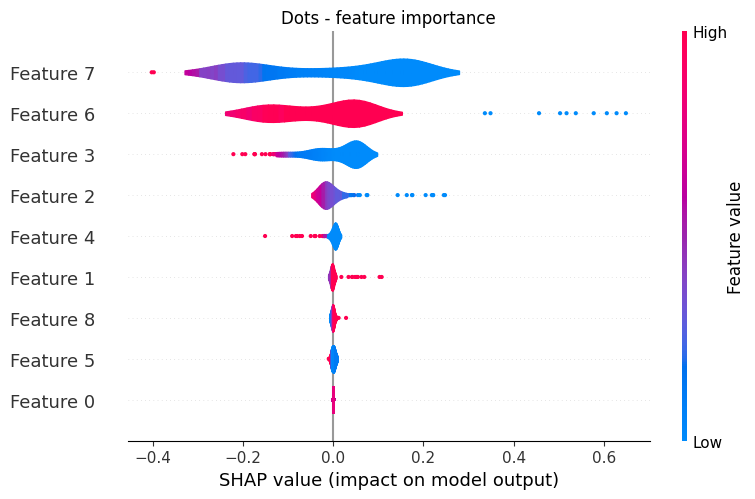

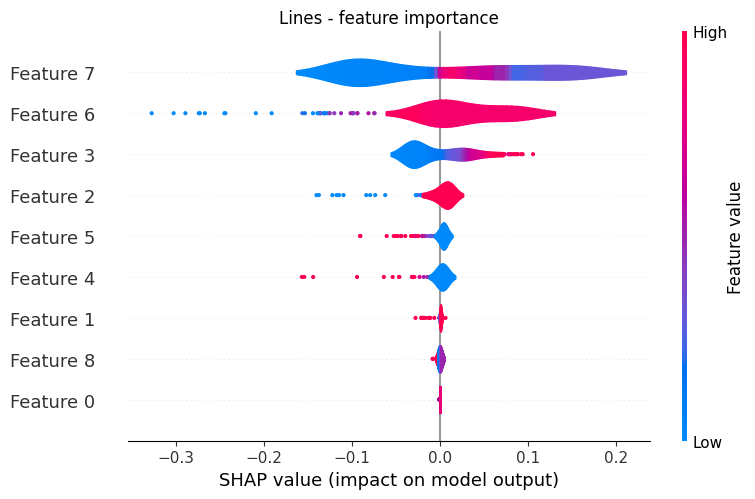

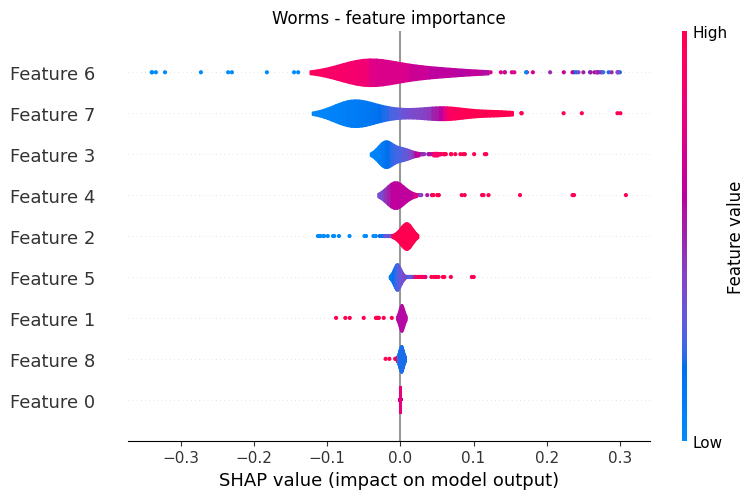

In [64]:
plt.title('Dots - feature importance')
shap.summary_plot(mlp_shap_values[0], X_test_shap, plot_type='violin')

plt.title('Lines - feature importance')
shap.summary_plot(mlp_shap_values[1], X_test_shap, plot_type='violin')

plt.title('Worms - feature importance')
shap.summary_plot(mlp_shap_values[2], X_test_shap, plot_type='violin')

## Bootstrap

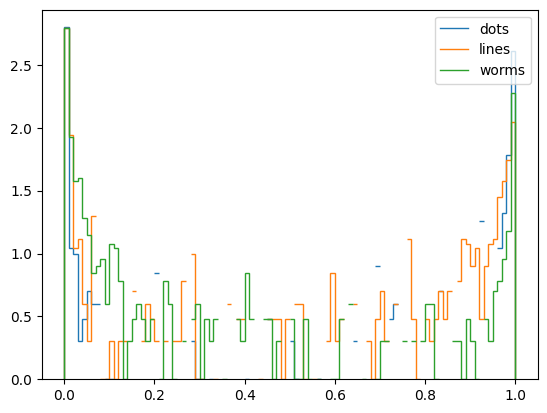

In [65]:
warnings.filterwarnings('ignore', message='divide by zero encountered in log10')
bootstrap(X, np.asarray(y), mlp, bs_samples)

## Jackknife cross-validation

In [66]:
mlp_jk = jackknife(X, np.asarray(y), mlp, jk_samples, jk_seed)
print(f'Jackknife score: {mlp_jk}')

Jackknife score: 0.00659942626953125


# Models comparison

In [67]:
print('Jackknife scores:')
print(f'SVC: {svc_jk}')
print(f'KNN: {knn_jk}')
print(f'RFC: {rfc_jk}')
print(f'MLP: {mlp_jk}')

Jackknife scores:
SVC: 0.04150390625
KNN: 0.069091796875
RFC: 0.059356689453125
MLP: 0.00659942626953125
